# **Hackathon by HackerEarth - House Habitability Prediction**

# **Import necessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from pycaret.regression import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, recall_score, precision_score, r2_score
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor

# **Data Exploration and Analysis**

In [ ]:
data = pd.read_csv("C:\Datasets\habitability\\train.csv")
data.head()

,Property_ID,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score
0,0x21e3,Apartment,106,NaN,1,Semi_Furnished,0.0,No,Once in a day - Morning,5.89,Slightly below average,Medium,90.0,3.86,71.98
1,0x68d4,Apartment,733,2.0,2,Unfurnished,1.0,No,Once in a day - Evening,4.37,Well below average,Medium,96.0,3.55,71.20
2,0x7d81,Apartment,737,4.0,2,Fully Furnished,0.0,No,Once in a day - Morning,7.45,Slightly below average,Medium,121.0,3.81,71.39
3,0x7a57,Apartment,900,3.0,2,Unfurnished,2.0,Yes,Once in a day - Morning,6.16,Well above average,Medium,100.0,1.34,31.46
4,0x9409,Bungalow,2238,14.0,6,Fully Furnished,0.0,No,All time,5.46,Well below average,Medium,116.0,4.77,93.70


In [ ]:
data.drop('Property_ID', axis=1, inplace=True)

In [ ]:
data.isnull().sum()

Property_Type                0
Property_Area                0
Number_of_Windows         1654
Number_of_Doors              0
Furnishing                1042
Frequency_of_Powercuts    1383
Power_Backup                 0
Water_Supply                 0
Traffic_Density_Score        0
Crime_Rate                 787
Dust_and_Noise            1219
Air_Quality_Index            0
Neighborhood_Review          0
Habitability_score           0
dtype: int64

In [ ]:
def FillNA(df, cols_to_fill):
    for i in cols_to_fill:
        if type(data[i][0])==np.float64:
            df[i] = df[i].fillna(df[i].mean())
        else:
            most_frequent_value = df[i].mode()[0]
            df[i].fillna(most_frequent_value, inplace=True)

    return df

cols_to_fill = ['Number_of_Windows', 'Frequency_of_Powercuts', 'Crime_Rate', 'Furnishing', 'Dust_and_Noise']

data = FillNA(data, cols_to_fill)

In [ ]:
len(data['Property_Type'].unique()), len(data['Furnishing'].unique()), len(data['Crime_Rate'].unique()), len(data['Dust_and_Noise'].unique()), len(data['Water_Supply'].unique()), len(data['Power_Backup'].unique())

(6, 3, 4, 3, 5, 3)

In [ ]:
data['Power_Backup'].unique()

array(['No', 'Yes', 'NOT MENTIONED'], dtype=object)

In [ ]:
data = pd.get_dummies(data,columns=['Property_Type'],drop_first=True)

## Handling Ordinal categorical features
data['Furnishing'].replace({'Unfurnished':1, 'Semi_Furnished':2, 'Fully Furnished':3}, inplace= True)

data['Power_Backup'].replace({'NOT MENTIONED':0, 'No':1, 'Yes':2}, inplace= True)

data['Water_Supply'].replace({'All time':3, 'Once in a day - Morning':2, 'Once in a day - Evening':2,'Once in two days':1,'NOT MENTIONED':0}, inplace= True)

data['Crime_Rate'].replace({'Well below average':4, 'Slightly below average':3, 'Slightly above average':2,'Well above average':1}, inplace= True)

data['Dust_and_Noise'].replace({'High':1, 'Medium':2, 'Low':3}, inplace= True)


In [ ]:
data.head()

,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score,Property_Type_Apartment,Property_Type_Bungalow,Property_Type_Container Home,Property_Type_Duplex,Property_Type_Single-family home
0,106,3.923768,1,2,0.0,1,2,5.89,3,2,90.0,3.86,71.98,1,0,0,0,0
1,733,2.000000,2,1,1.0,1,2,4.37,4,2,96.0,3.55,71.20,1,0,0,0,0
2,737,4.000000,2,3,0.0,1,2,7.45,3,2,121.0,3.81,71.39,1,0,0,0,0
3,900,3.000000,2,1,2.0,2,2,6.16,1,2,100.0,1.34,31.46,1,0,0,0,0
4,2238,14.000000,6,3,0.0,1,3,5.46,4,2,116.0,4.77,93.70,0,1,0,0,0


In [ ]:
data.shape

(39499, 18)

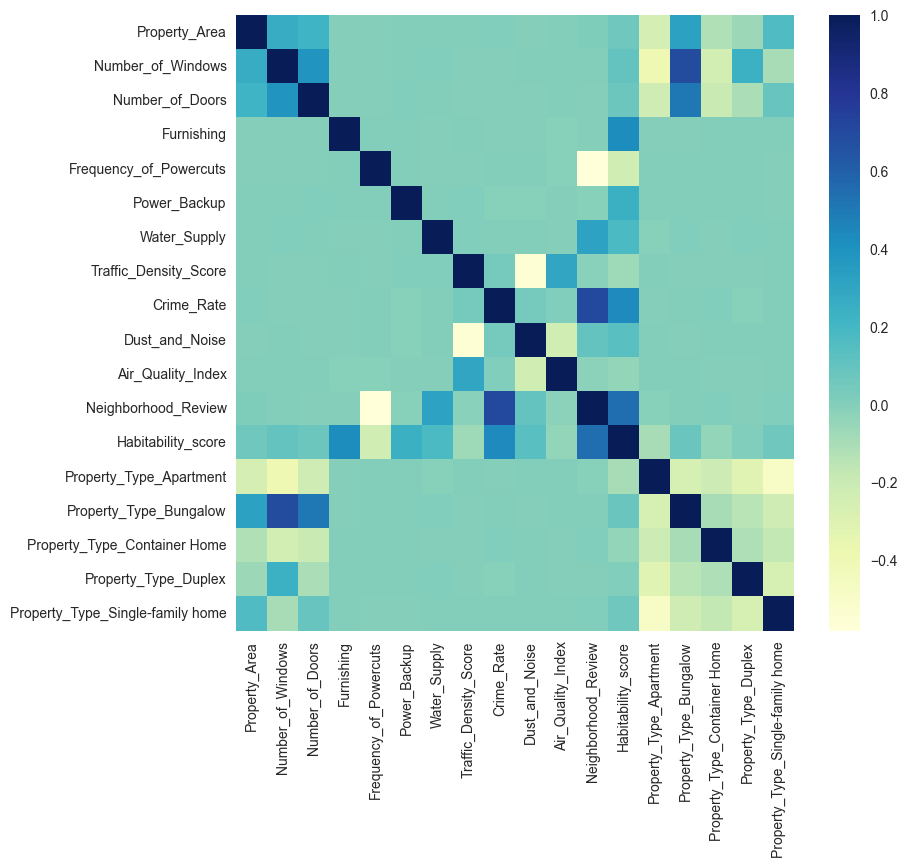

In [ ]:
plt.figure(figsize=(9,8))
seaborn.heatmap(data.corr(), cmap="YlGnBu", annot=False)
plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = data.corr()
# Set the threshold for correlation
threshold = 0.9
# Find highly correlated columns
highly_correlated_cols = set()
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] >= threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_cols.add(colname)

highly_correlated_cols

set()

In [ ]:
data.isnull().sum()

Property_Area                       0
Number_of_Windows                   0
Number_of_Doors                     0
Furnishing                          0
Frequency_of_Powercuts              0
Power_Backup                        0
Water_Supply                        0
Traffic_Density_Score               0
Crime_Rate                          0
Dust_and_Noise                      0
Air_Quality_Index                   0
Neighborhood_Review                 0
Habitability_score                  0
Property_Type_Apartment             0
Property_Type_Bungalow              0
Property_Type_Container Home        0
Property_Type_Duplex                0
Property_Type_Single-family home    0
dtype: int64

In [ ]:
data.describe()

,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review,Habitability_score,Property_Type_Apartment,Property_Type_Bungalow,Property_Type_Container Home,Property_Type_Duplex,Property_Type_Single-family home
count,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000,39499.000000
mean,1391.715638,3.923768,2.331375,1.934479,0.484678,1.205803,2.427606,6.354772,3.259298,1.971139,121.352566,3.735945,73.482297,0.369528,0.107294,0.072711,0.146991,0.290564
std,1953.287544,2.634047,1.179964,0.673764,0.738921,0.453187,0.628451,1.219681,0.904782,0.364617,62.384669,0.796843,14.118753,0.482683,0.309490,0.259664,0.354101,0.454029
min,100.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.280000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,494.000000,2.000000,1.000000,1.000000,0.000000,1.000000,2.000000,5.600000,3.000000,2.000000,95.000000,3.220000,69.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,932.000000,3.923768,2.000000,2.000000,0.000000,1.000000,2.000000,6.470000,4.000000,2.000000,113.000000,3.850000,75.760000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1770.000000,5.000000,3.000000,2.000000,1.000000,1.000000,3.000000,7.220000,4.000000,2.000000,140.000000,4.260000,82.260000,1.000000,0.000000,0.000000,0.000000,1.000000
max,28064.000000,15.000000,6.000000,3.000000,3.000000,2.000000,3.000000,9.910000,4.000000,3.000000,1044.000000,5.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


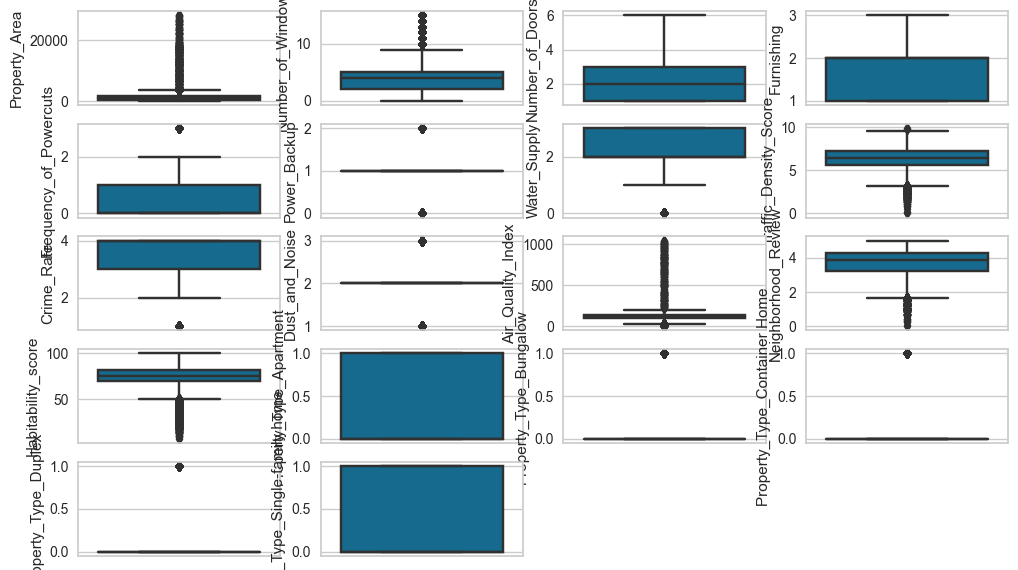

In [ ]:
c=1
plt.figure(figsize=(12, 10))

for i in data.columns:
    ax = plt.subplot(7, 4,c)
    c += 1
    seaborn.boxplot(data = data, y=i)

In [ ]:
# def outliers(val):

#     if val>(q3+threshold):
#         return q3
#     elif val<(q1-threshold):
#         return q1

#     return val

# for i in data.columns:

#     q3 = data[i].describe()['75%']
#     q1 = data[i].describe()['25%']

#     iqr = q3-q1
#     threshold = iqr*1.5
#     data[i] = data[i].apply(outliers)

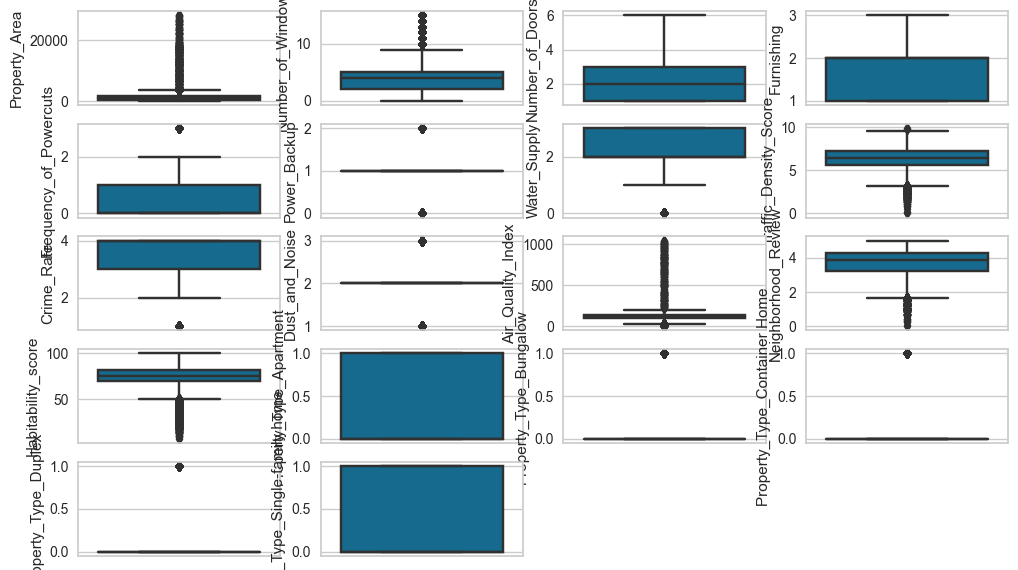

In [ ]:
c=1
plt.figure(figsize=(12, 10))

for i in data.columns:
    ax = plt.subplot(7, 4,c)
    c += 1
    seaborn.boxplot(data = data, y=i)

In [ ]:
data = data.drop_duplicates()
data.shape

(39499, 18)

In [ ]:
scaler = MinMaxScaler()

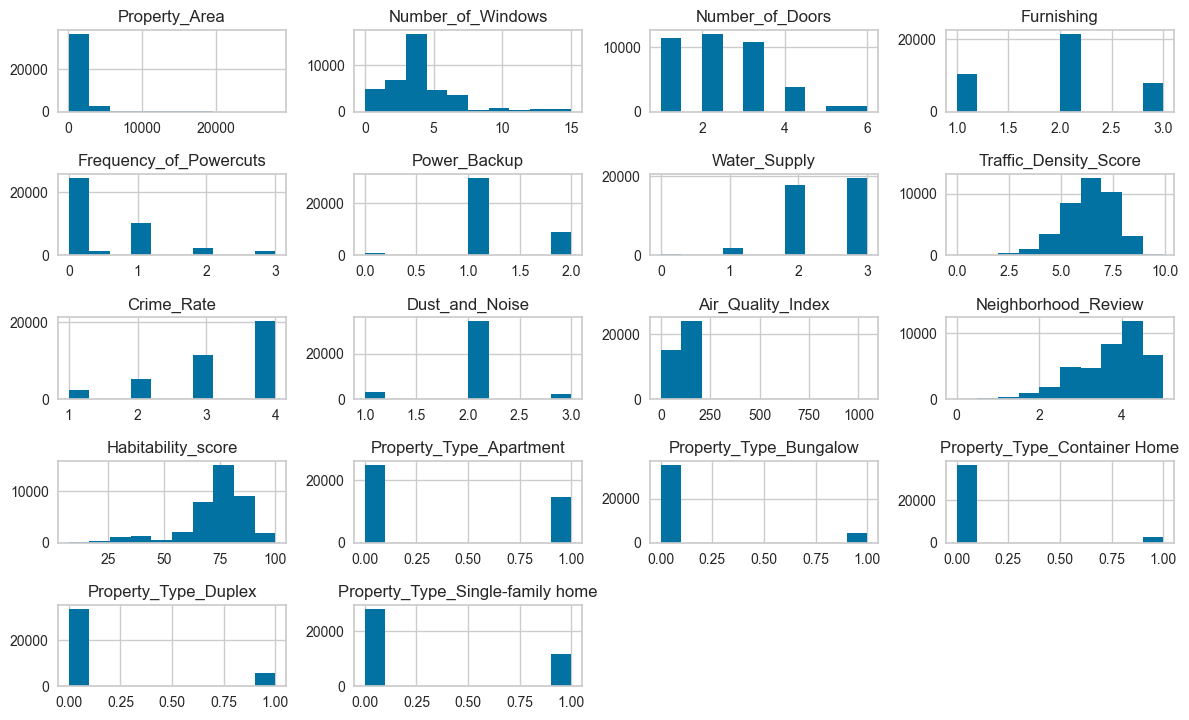

In [ ]:
c=1
plt.figure(figsize=(12, 10))

for i in data.columns:
    plt.subplot(7, 4, c)
    c += 1
    data[i].hist()
    plt.title(i)

plt.tight_layout()
plt.show()

# **Split Data into Train and Test partitions and scale for training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('Habitability_score', axis=1), data['Habitability_score'], test_size=0.20)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# **Make Predictions**

In [ ]:
# mean_squared_error, f1_score, recall_score, precision_score, r2_score

In [ ]:
LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = LRmodel.predict(X_test)

print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2 Score: 0.5761858007480329
MSE: 88.40295257210508


In [ ]:
# Set the parameters for XGBoost
params = {
    'max_depth': 3,
    'n_estimators': 400,
}

# Train the XGBoost model
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2 Score: 0.7887115496972474
MSE: 44.072432882417466


In [ ]:
# Creating and training the Decision Tree Regression model
DTRModel = DecisionTreeRegressor(max_depth=4)
DTRModel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = (DTRModel.predict(X_test))

print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2 Score: 0.6455701984992328
MSE: 73.93013492118745


In [ ]:
# Creating and training the Random Forest Regression model
RFRmodel = RandomForestRegressor(n_estimators=300)
RFRmodel.fit(X_train, y_train)

# Making predictions on the test set
y_pred = (RFRmodel.predict(X_test))

# Calculating the Accuracy
print(f'R2 Score: {r2_score(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2 Score: 0.8315076903171701
MSE: 35.14563147706174


In [ ]:
# Initialize the regression setup
regression_setup = setup(data=data, target='Habitability_score', train_size=0.8)

# Compare different regression models
best_model = compare_models()

,Description,Value
0,Session id,6894
1,Target,Habitability_score
2,Target type,Regression
3,Original data shape,"(39499, 18)"
4,Transformed data shape,"(39499, 18)"
5,Transformed train set shape,"(31599, 18)"
6,Transformed test set shape,"(7900, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,4.5308,35.2480,5.9364,0.8229,0.0938,0.0685,2.0270
catboost,CatBoost Regressor,4.7330,36.8905,6.0732,0.8146,0.0964,0.0715,2.2630
lightgbm,Light Gradient Boosting Machine,4.7820,37.3789,6.1133,0.8122,0.0960,0.0719,0.1950
et,Extra Trees Regressor,4.6640,37.8192,6.1493,0.8099,0.0970,0.0705,1.4560
xgboost,Extreme Gradient Boosting,4.8280,38.8058,6.2288,0.8050,0.0990,0.0729,0.5320
gbr,Gradient Boosting Regressor,5.6406,49.8303,7.0587,0.7497,0.1123,0.0857,0.6800
dt,Decision Tree Regressor,6.0349,67.4778,8.2139,0.6608,0.1303,0.0908,0.1410
ada,AdaBoost Regressor,7.1538,80.2468,8.9574,0.5967,0.1507,0.1133,0.6710
lar,Least Angle Regression,7.4332,86.5541,9.3029,0.5652,0.1618,0.1222,0.1130
lr,Linear Regression,7.4332,86.5541,9.3029,0.5652,0.1618,0.1222,1.1640


In [ ]:
xg=XGBRegressor(random_state=1,learning_rate=0.1)
rf=RandomForestRegressor(random_state=1)
ct=CatBoostRegressor(random_state=1)
hgb=HistGradientBoostingRegressor(random_state=1,l2_regularization=0.1)
lgbm = LGBMRegressor(random_state=1,learning_rate=0.1)

estimator_list = [
    ('ct',ct),
    ('rf',rf),
    ('xg',xg),
    ('lgbm',lgbm)
]

stack_model = StackingRegressor(
    estimators=estimator_list,final_estimator=HistGradientBoostingRegressor(random_state=1,l2_regularization=0.1)
)

# Train stacked model
stack_model.fit(X_train, y_train)

Learning rate set to 0.070653
0:	learn: 13.3847624	total: 6.17ms	remaining: 6.16s
1:	learn: 12.7929781	total: 11.2ms	remaining: 5.59s
2:	learn: 12.2552462	total: 16.6ms	remaining: 5.51s
3:	learn: 11.7639939	total: 21.9ms	remaining: 5.46s
4:	learn: 11.3174763	total: 26.2ms	remaining: 5.2s
5:	learn: 10.9052202	total: 30.4ms	remaining: 5.04s
6:	learn: 10.5172564	total: 35.5ms	remaining: 5.03s
7:	learn: 10.1843978	total: 40.3ms	remaining: 5s
8:	learn: 9.8798431	total: 45.2ms	remaining: 4.97s
9:	learn: 9.6038100	total: 49.9ms	remaining: 4.94s
10:	learn: 9.3436595	total: 55.3ms	remaining: 4.97s
11:	learn: 9.1051388	total: 59.7ms	remaining: 4.91s
12:	learn: 8.9028304	total: 64.5ms	remaining: 4.89s
13:	learn: 8.7038593	total: 70.1ms	remaining: 4.94s
14:	learn: 8.5353583	total: 74.7ms	remaining: 4.9s
15:	learn: 8.3767618	total: 78.9ms	remaining: 4.85s
16:	learn: 8.2327423	total: 83.9ms	remaining: 4.85s
17:	learn: 8.0969568	total: 88.6ms	remaining: 4.83s
18:	learn: 7.9851985	total: 93.1ms	remain

StackingRegressor(estimators=[('ct',
                               <catboost.core.CatBoostRegressor object at 0x000001E70A14D990>),
                              ('rf', RandomForestRegressor(random_state=1)),
                              ('xg',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_t...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=1, ...)),
                              ('lgbm', LGBMRegressor(random_state=1))],
                  final_estimator=HistGradientBoostingRegressor(l2_regularization=0.1,
                                                                random_state=1))

In [ ]:
print("Train data score: ",stack_model.score(X_train,y_train))
print("Test data score: ",stack_model.score(X_test,y_test))

Train data score:  0.9132636670907169
Test data score:  0.8390190993368438


In [ ]:
test = pd.read_csv("C:\Datasets\habitability\\test.csv")
ID = test['Property_ID']
test.drop('Property_ID', axis=1, inplace=True)
test.isnull().sum()

Property_Type               0
Property_Area               0
Number_of_Windows         445
Number_of_Doors             0
Furnishing                257
Frequency_of_Powercuts    366
Power_Backup                0
Water_Supply                0
Traffic_Density_Score       0
Crime_Rate                212
Dust_and_Noise            330
Air_Quality_Index           0
Neighborhood_Review         0
dtype: int64

In [ ]:
test.head()

,Property_Type,Property_Area,Number_of_Windows,Number_of_Doors,Furnishing,Frequency_of_Powercuts,Power_Backup,Water_Supply,Traffic_Density_Score,Crime_Rate,Dust_and_Noise,Air_Quality_Index,Neighborhood_Review
0,Apartment,293,3.0,1,Unfurnished,0.0,No,Once in a day - Morning,7.28,Well above average,Medium,152.0,2.52
1,Apartment,586,4.0,1,Semi_Furnished,0.0,No,Once in a day - Evening,7.63,Well below average,Medium,92.0,4.16
2,Container Home,305,1.0,2,Semi_Furnished,1.0,No,All time,5.39,Slightly above average,Medium,90.0,2.92
3,Apartment,258,2.0,1,Semi_Furnished,1.0,No,All time,7.53,Slightly below average,Medium,158.0,3.45
4,Bungalow,3031,12.0,4,Fully Furnished,0.0,No,All time,8.79,Well above average,High,186.0,2.72


In [ ]:
test = FillNA(test, cols_to_fill)
test.isnull().sum()

Property_Type             0
Property_Area             0
Number_of_Windows         0
Number_of_Doors           0
Furnishing                0
Frequency_of_Powercuts    0
Power_Backup              0
Water_Supply              0
Traffic_Density_Score     0
Crime_Rate                0
Dust_and_Noise            0
Air_Quality_Index         0
Neighborhood_Review       0
dtype: int64

In [ ]:
test = pd.get_dummies(test,columns=['Property_Type'],drop_first=True)

## Handling Ordinal categorical features
test['Furnishing'].replace({'Unfurnished':1, 'Semi_Furnished':2, 'Fully Furnished':3}, inplace= True)

test['Power_Backup'].replace({'NOT MENTIONED':0, 'No':1, 'Yes':2}, inplace= True)

test['Water_Supply'].replace({'All time':3, 'Once in a day - Morning':2, 'Once in a day - Evening':2,'Once in two days':1,'NOT MENTIONED':0}, inplace= True)

test['Crime_Rate'].replace({'Well below average':4, 'Slightly below average':3, 'Slightly above average':2,'Well above average':1}, inplace= True)

test['Dust_and_Noise'].replace({'High':1, 'Medium':2, 'Low':3}, inplace= True)

In [ ]:
# Calculate the correlation matrix
correlation_matrix = test.corr()
# Set the threshold for correlation
threshold = 0.9
# Find highly correlated columns
highly_correlated_cols = set()
cols = correlation_matrix.columns
for i in range(len(cols)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] >= threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_cols.add(colname)

highly_correlated_cols

set()

In [ ]:
test = scaler.fit_transform(test)

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [ ]:
test_preds = stack_model.predict(test)

In [ ]:
test_preds

array([29.03396062, 80.124947  , 66.34250697, ..., 74.06955276,
       79.6439114 , 80.88440999])

In [ ]:
sub = pd.DataFrame({'Habitability_score':test_preds})

In [ ]:
sub = pd.concat([ID, sub], axis=1)
sub

,Property_ID,Habitability_score
0,0x6e93,29.033961
1,0x8787,80.124947
2,0x6c17,66.342507
3,0x9dbd,72.527723
4,0xbfde,75.662735
...,...,...
10495,0x423d,63.393409
10496,0x78c5,80.624108
10497,0xbf3,74.069553
10498,0x305b,79.643911


In [ ]:
sub.to_csv('C:\VIT Material\VIT material\Projects\HackerEarth-Habitability\sub.csv', index=False)